<a href="https://colab.research.google.com/github/xerox010/Fraud_Detection_2023/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,precision_recall_curve,roc_curve, auc
import xgboost as xgb

Mounting the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# loading the dataset to a Pandas DataFrame
#credit_card_data = pd.read_csv('/content/drive/MyDrive/Machine Learning/Project 1:Credit card Fraud /creditcard.csv')

# loading the dataset to a Pandas DataFrame
credit_card_data = pd.read_csv('/content/drive/MyDrive/Machine Learning/Project 1:Credit card Fraud /creditcard_2023.csv')

In [4]:
# first 5 rows of the dataset
credit_card_data.head().style.background_gradient(cmap='Purples')

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.100000,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.370000,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.540000,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.440000,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.970000,0


In [5]:
credit_card_data.tail().style.background_gradient(cmap='Purples')

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,-1.161847,1.430971,-1.330500,-1.580730,-1.363454,0.287766,-1.480796,-1.520928,-1.376970,1.789103,-0.751011,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.160000,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,-0.210817,0.173590,-0.539948,0.738315,-0.812043,0.870447,-0.545184,-0.575991,-0.664313,0.101604,-0.550260,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.400000,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,-0.144495,0.477582,-0.461849,-0.606100,-0.395126,-0.040673,-0.370201,-0.729002,-0.251679,-0.343196,-0.076417,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.850000,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,-0.080078,-0.324934,0.335215,0.464177,-0.390369,0.893881,0.477402,0.848443,0.930280,-0.481058,0.288186,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.830000,1
568629,568629,-0.795144,0.433236,-0.649140,0.374732,-0.244976,-0.603493,-0.347613,-0.340814,0.253971,-0.513556,0.892136,-1.153011,0.489197,-1.062488,0.207773,-0.917240,-0.936114,-0.823688,-0.330408,-0.621378,0.534853,-0.291514,0.157303,0.931030,-0.349423,-1.090974,-1.575113,0.722936,21493.920000,1


In [6]:
# dataset informations
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

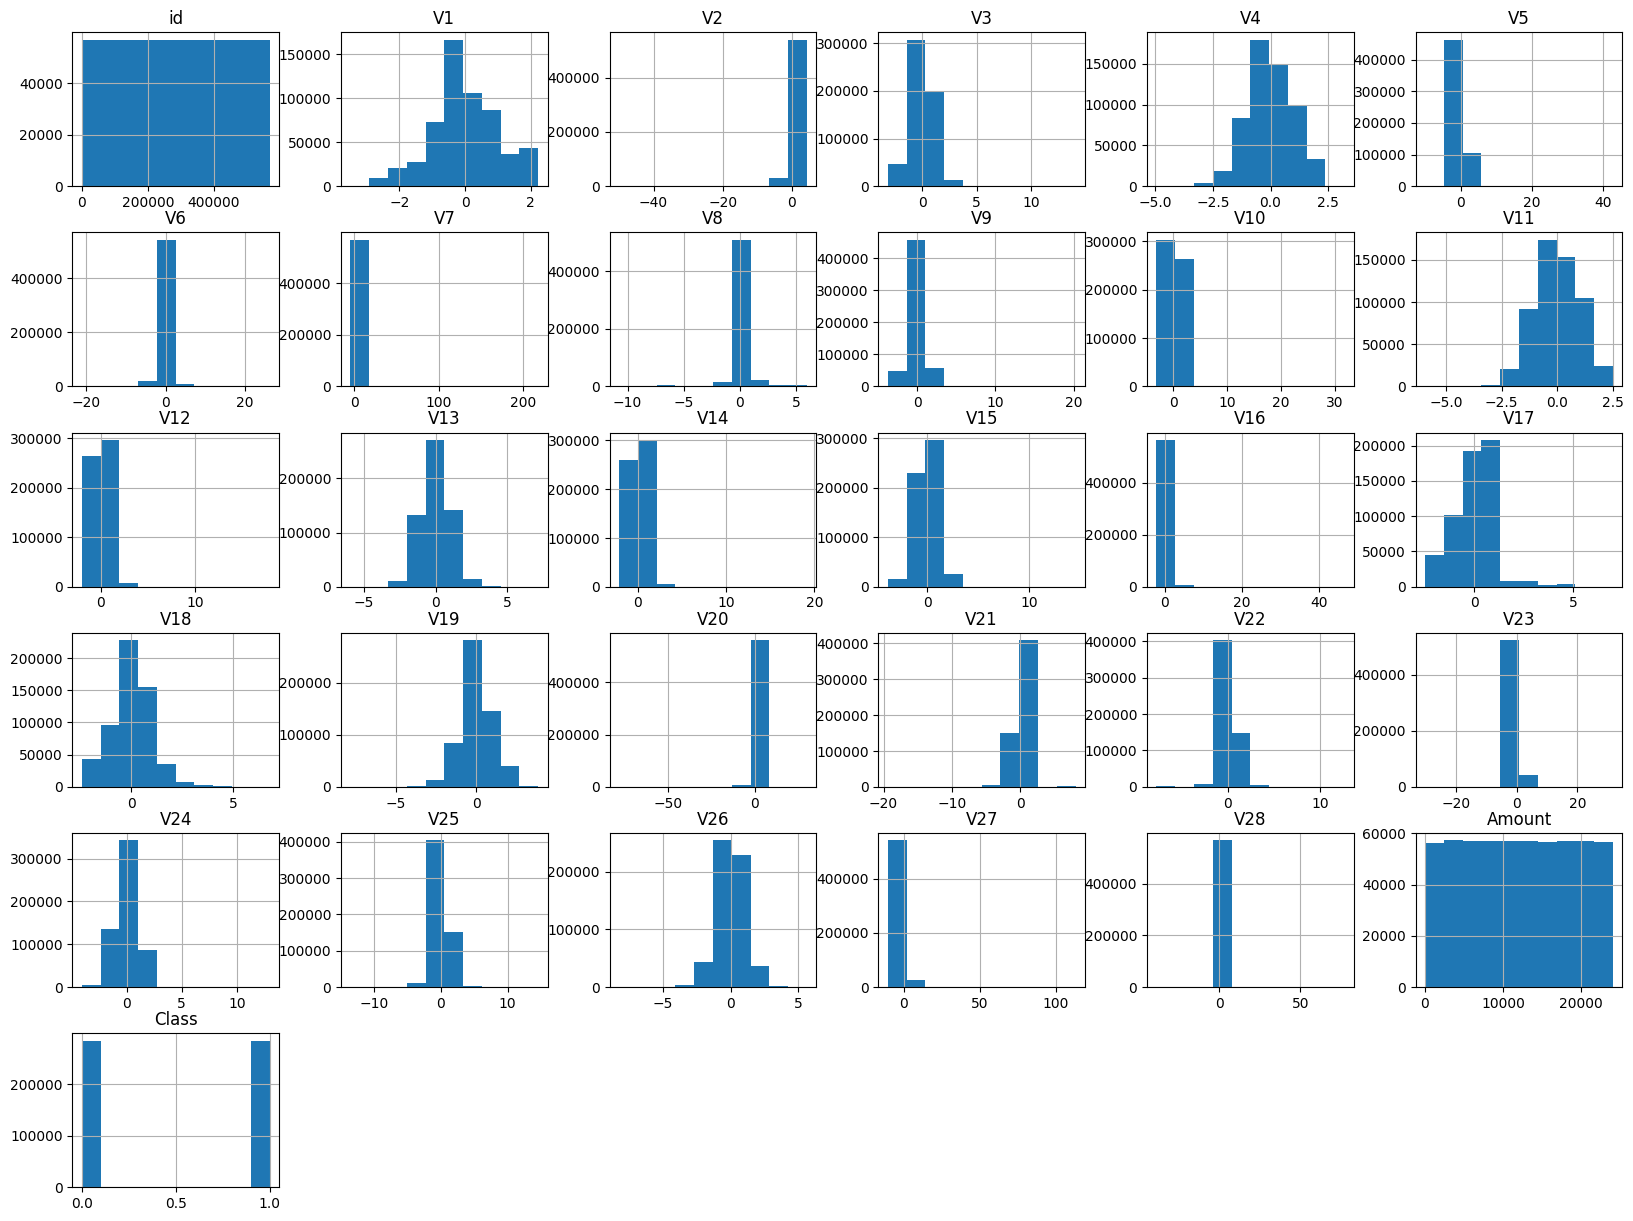

In [7]:
credit_card_data.hist(figsize=(20, 15))
plt.show()

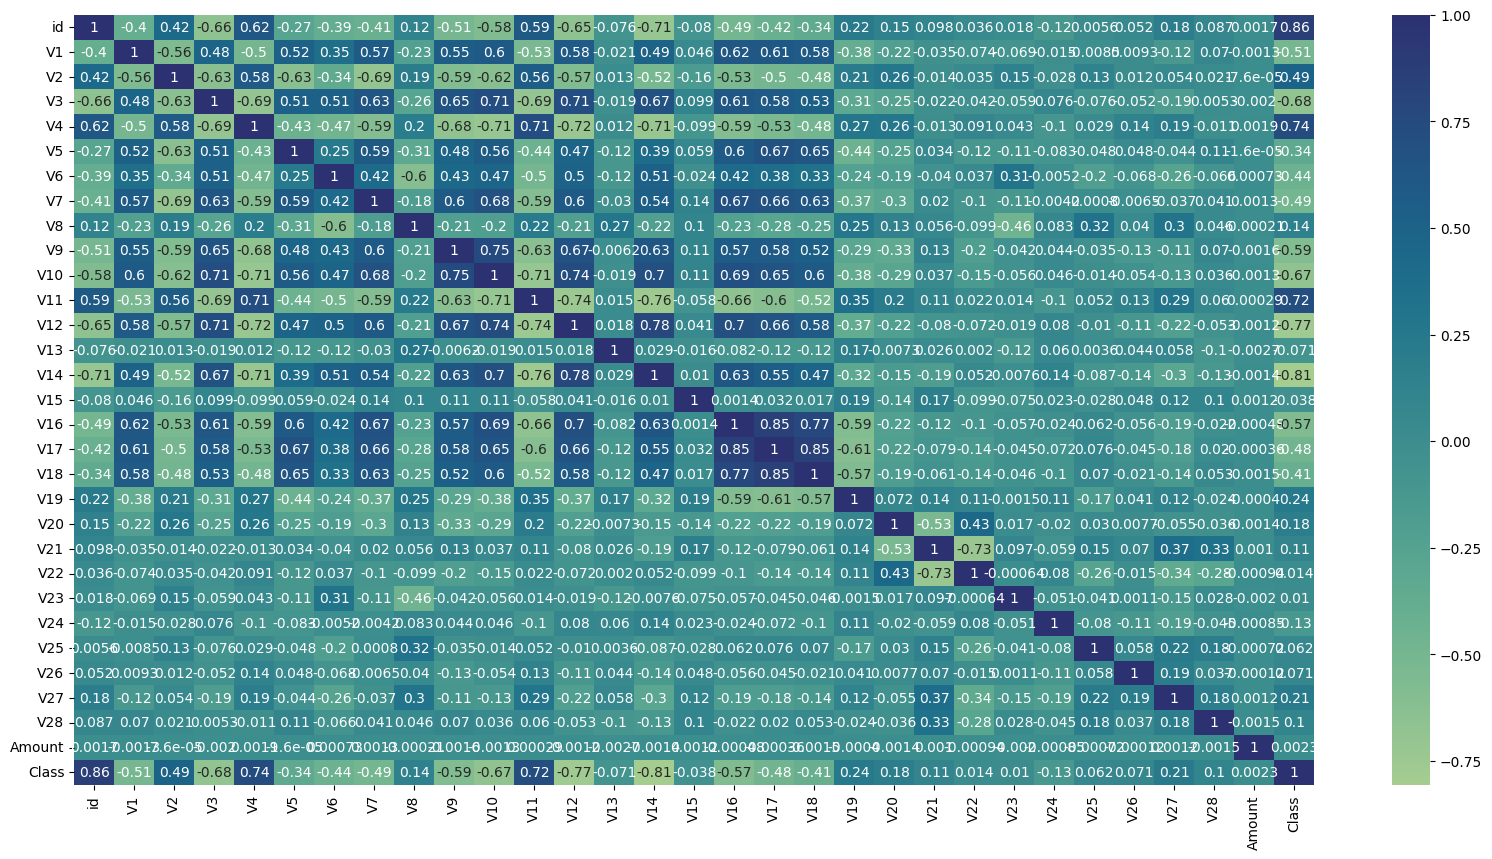

In [8]:
paper = plt.figure(figsize=[20,10])
sns.heatmap(credit_card_data.corr(),cmap='crest',annot=True)
plt.show()

In [9]:
# checking the number of missing values in each column
credit_card_data.isnull().sum()

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
# distribution of legit transactions & fraudulent transactions
credit_card_data['Class'].value_counts()

0    284315
1    284315
Name: Class, dtype: int64

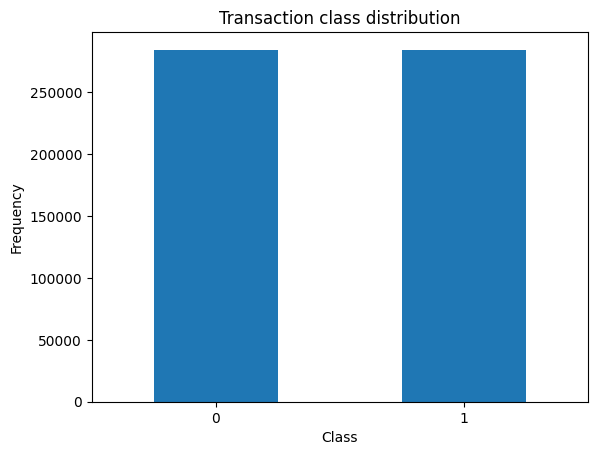

In [11]:
count_classes = pd.value_counts(credit_card_data['Class'], sort=True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Transaction class distribution")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

Create Histogram with Density Curve Using Seaborn

In [ ]:
sns.displot(credit_card_data, kde=True, bins=15)

This Dataset is highly unblanced

0 --> Normal Transaction

1 --> fraudulent transaction

In [13]:
# separating the data for analysis
legit = credit_card_data[credit_card_data.Class == 0]
fraud = credit_card_data[credit_card_data.Class == 1]

In [14]:
print(legit.shape)
print(fraud.shape)

(284315, 31)
(284315, 31)


In [15]:
# statistical measures of the data
legit.Amount.describe()

count    284315.000000
mean      12026.313506
std        6929.500715
min          50.120000
25%        6034.540000
50%       11996.900000
75%       18040.265000
max       24039.930000
Name: Amount, dtype: float64

In [16]:
fraud.Amount.describe()

count    284315.000000
mean      12057.601763
std        6909.750891
min          50.010000
25%        6074.640000
50%       12062.450000
75%       18033.780000
max       24039.930000
Name: Amount, dtype: float64

In [17]:
# compare the values for both transactions
credit_card_data.groupby('Class').mean()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,142442.987714,0.505761,-0.491878,0.682095,-0.735981,0.338639,0.435088,0.491234,-0.144294,0.585522,...,-0.179851,-0.10964,-0.014098,-0.010255,0.130107,-0.061847,-0.071052,-0.214002,-0.102024,12026.313506
1,426186.012286,-0.505761,0.491878,-0.682095,0.735981,-0.338639,-0.435088,-0.491234,0.144294,-0.585522,...,0.179851,0.10964,0.014098,0.010255,-0.130107,0.061847,0.071052,0.214002,0.102024,12057.601763


Under-Sampling

Build a sample dataset containing similar distribution of normal transactions and Fraudulent Transactions

Number of Fraudulent Transactions --> 492

In [51]:
legit_sample = legit.sample(n=150000)

Changing the Number of the fraud ammount

In [52]:
fraud_sample = fraud.sample(n=10000)

Concatenating two DataFrames

In [53]:
new_dataset = pd.concat([legit_sample, fraud_sample], axis=0)

In [21]:
new_dataset.head().style.background_gradient(cmap='Purples')

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
144521,144521,-0.297932,-0.012571,0.654882,-0.225900,0.327910,1.539298,0.288517,0.248080,0.189557,0.513584,-0.069297,1.320704,-1.017093,1.432761,0.448429,-0.224749,1.107440,-0.384381,-0.291378,-0.271892,-0.052948,0.509086,-0.007162,-2.150691,-0.486442,-0.240462,0.181497,0.137009,4094.970000,0
89377,89377,-0.254691,-0.796571,1.799178,-2.097479,-0.214776,0.207277,0.669944,-0.200838,0.526157,0.211750,-1.072952,1.292600,1.615531,0.362742,0.369635,-0.250980,0.346495,1.662412,-1.025818,-0.531740,-0.201009,-0.132258,0.045081,0.847677,0.247983,-2.211157,-0.111262,0.311168,22367.980000,0
272487,272487,0.135477,-0.066509,0.241464,-0.833677,0.729373,-0.122533,0.860101,-0.207656,0.535712,0.331197,-1.571141,0.225781,-0.330857,0.356024,0.897346,0.581396,0.518912,1.127483,-0.087337,-0.140345,-0.003434,0.854072,-0.354180,-1.214445,-0.651007,-0.253194,0.171003,0.623769,2303.520000,0
85600,85600,-0.322372,-0.036983,1.219785,-0.902252,0.338629,0.501595,0.677851,-0.197018,0.873181,1.313719,-0.295739,0.500523,-0.549492,0.544327,0.534919,0.814033,0.120892,0.812481,0.218411,0.088411,-0.181817,-0.102531,-0.228729,-0.878047,-0.625172,0.066005,-1.474074,-2.512004,23512.610000,0
64811,64811,-0.199389,-0.907677,1.487502,-1.507280,-0.283081,0.960399,0.826340,-0.084304,1.592725,-0.034758,-0.214336,1.654992,-0.671099,0.512533,-0.939587,-0.099589,0.628988,0.493810,0.747117,0.586987,0.060109,0.876538,0.675714,0.145409,-0.178022,0.211532,-0.171088,0.280308,19507.540000,0


In [22]:
new_dataset.tail().style.background_gradient(cmap='Purples')

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
486038,486038,-0.273996,0.209349,-0.073720,0.149272,-0.092902,-0.171026,-0.129731,-0.026235,-0.369394,-0.310407,0.629511,-0.545985,-1.104195,-0.479304,0.562570,-0.534839,-0.578345,-0.118715,0.783451,0.043917,0.233268,0.110590,-0.068729,-0.075507,-0.160528,-0.753379,0.047795,0.060218,17924.460000,1
481382,481382,0.184297,0.015119,-0.494169,0.133882,1.422713,-1.021321,-0.472846,-0.388141,-0.087353,-0.312824,0.217265,-0.440477,-1.150725,-0.571524,-0.427746,-0.498951,-0.240185,-0.258496,0.209280,0.243860,-0.220119,-0.180868,-3.047165,0.765246,-1.114308,-0.041662,0.567673,0.762045,18598.870000,1
543487,543487,-1.032673,-1.548512,-0.515920,0.044188,-0.606529,-0.115313,-0.052944,0.121198,-0.303242,-0.420810,-0.268097,-0.557705,0.449496,-0.499481,0.657374,0.093462,-0.393093,-0.528753,0.498061,-0.548590,0.107083,0.066629,-1.715390,-0.227167,-0.363393,0.163159,-0.036896,-1.471899,18499.830000,1
419176,419176,-0.687600,-0.364047,-0.853639,1.486952,2.653296,-2.086818,-0.152934,-0.048439,-1.029432,-0.397124,1.311705,-0.753325,-0.916452,-1.369475,0.481133,-0.054017,0.735127,1.189288,-0.489861,-0.538312,-0.023749,0.257562,1.221959,-0.768928,0.334028,1.308018,0.383119,1.751292,10405.130000,1
306340,306340,-0.381861,0.909077,-0.791694,1.109940,0.773270,-1.503689,-0.051696,-0.000921,-1.130769,-1.110550,1.665897,-1.410657,-0.299691,-1.464579,-1.979807,-0.461754,-0.318544,0.413112,-2.126796,0.401131,0.138996,-0.408536,-0.717947,-0.473984,1.800860,0.729133,0.903159,1.228145,17972.840000,1


In [54]:
new_dataset['Class'].value_counts()

0    150000
1     10000
Name: Class, dtype: int64

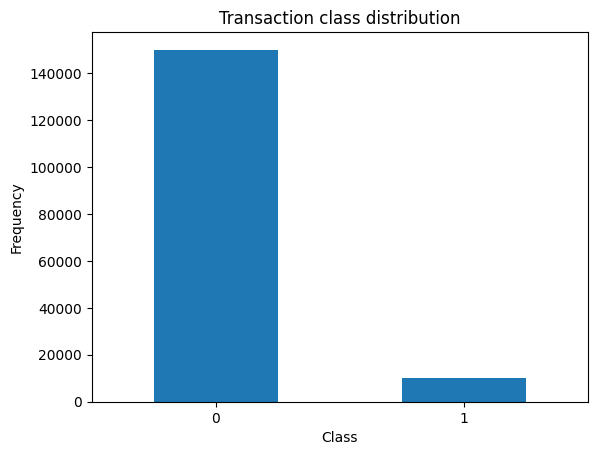

In [55]:
count_classes = pd.value_counts(new_dataset['Class'], sort=True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Transaction class distribution")
plt.xticks(range(2))
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

Create Histogram with Density Curve Using Seaborn

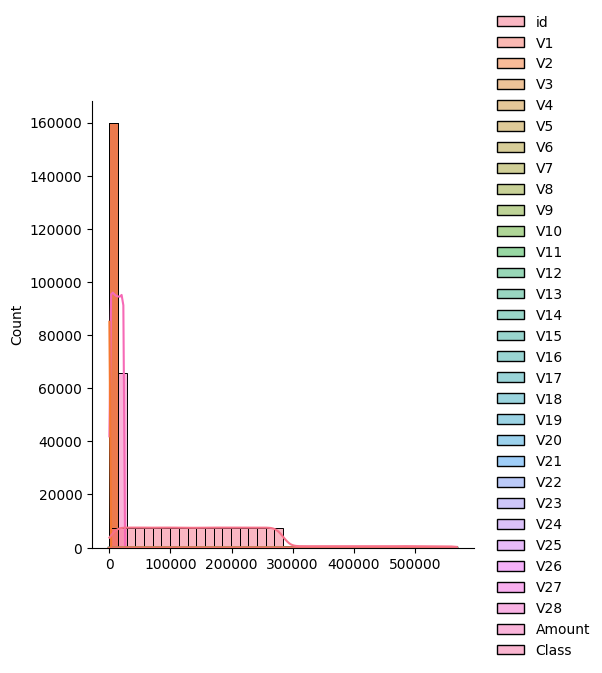

In [56]:
sns.displot(new_dataset , kde=True, bins=40)

In [26]:
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 144521 to 306340
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      20000 non-null  int64  
 1   V1      20000 non-null  float64
 2   V2      20000 non-null  float64
 3   V3      20000 non-null  float64
 4   V4      20000 non-null  float64
 5   V5      20000 non-null  float64
 6   V6      20000 non-null  float64
 7   V7      20000 non-null  float64
 8   V8      20000 non-null  float64
 9   V9      20000 non-null  float64
 10  V10     20000 non-null  float64
 11  V11     20000 non-null  float64
 12  V12     20000 non-null  float64
 13  V13     20000 non-null  float64
 14  V14     20000 non-null  float64
 15  V15     20000 non-null  float64
 16  V16     20000 non-null  float64
 17  V17     20000 non-null  float64
 18  V18     20000 non-null  float64
 19  V19     20000 non-null  float64
 20  V20     20000 non-null  float64
 21  V21     20000 non-null  float

Create histograms for each column

In [ ]:
new_dataset.hist(figsize=(20, 15))
plt.show()

In [ ]:
paper = plt.figure(figsize=[20,10])
sns.heatmap(new_dataset.corr(),cmap='crest',annot=True)
plt.show()

In [57]:
new_dataset.groupby('Class').mean()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,142327.4349,0.506484,-0.489159,0.683120,-0.737151,0.336866,0.436604,0.491433,-0.144582,0.586666,...,-0.181388,-0.109179,-0.012289,-0.011896,0.124106,-0.060031,-0.069015,-0.215676,-0.100833,12018.985508
1,426479.9841,-0.510231,0.502738,-0.689465,0.740017,-0.347319,-0.422062,-0.494340,0.127275,-0.592644,...,0.187117,0.098338,0.023440,0.035630,-0.130939,0.051824,0.068701,0.201088,0.090903,12037.350098


Splitting the data into Features & Targets

In [58]:
X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']

In [29]:
print(X)

            id        V1        V2        V3        V4        V5        V6  \
144521  144521 -0.297932 -0.012571  0.654882 -0.225900  0.327910  1.539298   
89377    89377 -0.254691 -0.796571  1.799178 -2.097479 -0.214776  0.207277   
272487  272487  0.135477 -0.066509  0.241464 -0.833677  0.729373 -0.122533   
85600    85600 -0.322372 -0.036983  1.219785 -0.902252  0.338629  0.501595   
64811    64811 -0.199389 -0.907677  1.487502 -1.507280 -0.283081  0.960399   
...        ...       ...       ...       ...       ...       ...       ...   
486038  486038 -0.273996  0.209349 -0.073720  0.149272 -0.092902 -0.171026   
481382  481382  0.184297  0.015119 -0.494169  0.133882  1.422713 -1.021321   
543487  543487 -1.032673 -1.548512 -0.515920  0.044188 -0.606529 -0.115313   
419176  419176 -0.687600 -0.364047 -0.853639  1.486952  2.653296 -2.086818   
306340  306340 -0.381861  0.909077 -0.791694  1.109940  0.773270 -1.503689   

              V7        V8        V9  ...       V20       V21  

In [30]:
print(Y)

144521    0
89377     0
272487    0
85600     0
64811     0
         ..
486038    1
481382    1
543487    1
419176    1
306340    1
Name: Class, Length: 20000, dtype: int64


Split the data into Training data & Testing Data with Train_Test_split

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=2)

Split the data into Training data & Testing Data with K-fold

In [ ]:
#k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

In [ ]:
# Iterate over the folds
#for train_index, test_index in k_fold.split(X, Y):
   # X_train, X_test = X.iloc[train_index], X.iloc[test_index]
   # Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

In [60]:
print(X.shape, X_train.shape, X_test.shape)

(160000, 30) (112000, 30) (48000, 30)


Model Training

Logistic Regression,Random Forest, Dicision Tree, GB, xgbrf,Adaboost

In [61]:
models={
    "Logistic Regression" :LogisticRegression(max_iter=200),
    "Random Forest" :RandomForestClassifier(),
    "Gradient Boost" :GradientBoostingClassifier(),
    "Decision Tree" :DecisionTreeClassifier(),
    "XGCLF" : xgb.XGBRFClassifier(),
    "Adaboost" : AdaBoostClassifier()
}

In [62]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, Y_train)

    # model Prediction
    X_train_prediction = model.predict(X_train)
    X_test_prediction = model.predict(X_test)

    # accuracy on training data

    training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
    #conf_matrix = confusion_matrix(X_train_prediction, Y_train)
    #clas_rep = classification_report(X_train_prediction, Y_train)

    # accuracy on test data

    test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
    conf_matrix = confusion_matrix(X_test_prediction, Y_test)
    clas_rep = classification_report(X_test_prediction, Y_test)

    print(list(models.keys())[i])
    print('------------------------------------------------')

    print(f'\n Accuracy on Training data : {training_data_accuracy*100:.2f}%')

    print(f' Accuracy score on Test Data : {test_data_accuracy*100:.2f}%')
    print('------------------------------------------------')
    #print(conf_matrix,'\n')
    #print(clas_rep)
    print('\n')

Logistic Regression
------------------------------------------------

 Accuracy on Training data : 89.78%
 Accuracy score on Test Data : 89.89%
------------------------------------------------


Random Forest
------------------------------------------------

 Accuracy on Training data : 100.00%
 Accuracy score on Test Data : 99.98%
------------------------------------------------


Gradient Boost
------------------------------------------------

 Accuracy on Training data : 100.00%
 Accuracy score on Test Data : 99.98%
------------------------------------------------


Decision Tree
------------------------------------------------

 Accuracy on Training data : 100.00%
 Accuracy score on Test Data : 99.98%
------------------------------------------------


XGCLF
------------------------------------------------

 Accuracy on Training data : 99.99%
 Accuracy score on Test Data : 99.98%
------------------------------------------------


Adaboost
--------------------------------------------

Displaying the ROC curve, Precision-Recall curve, and Confusion Matrix

Logistic Regression


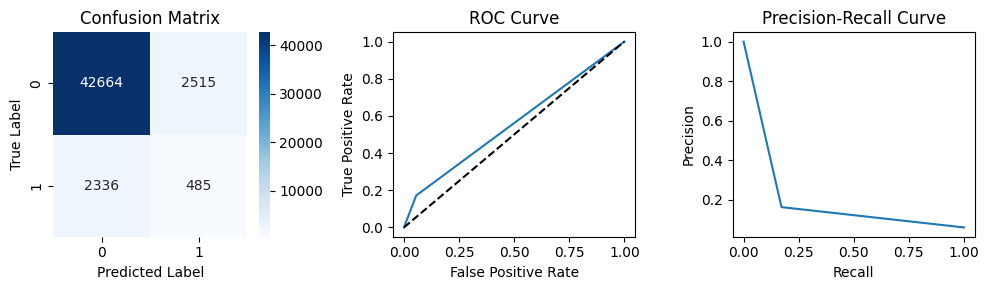

Random Forest


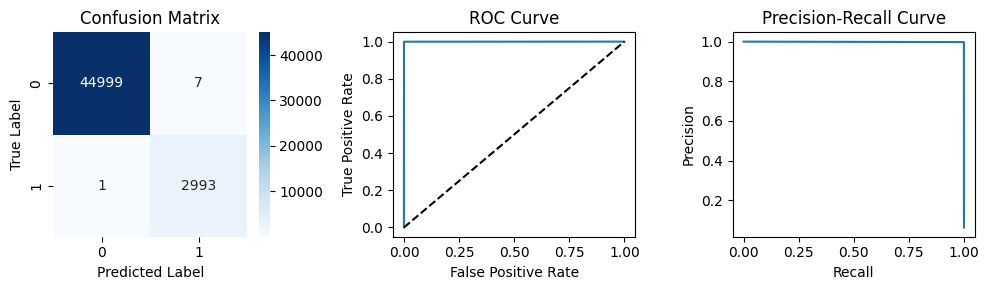

Gradient Boost


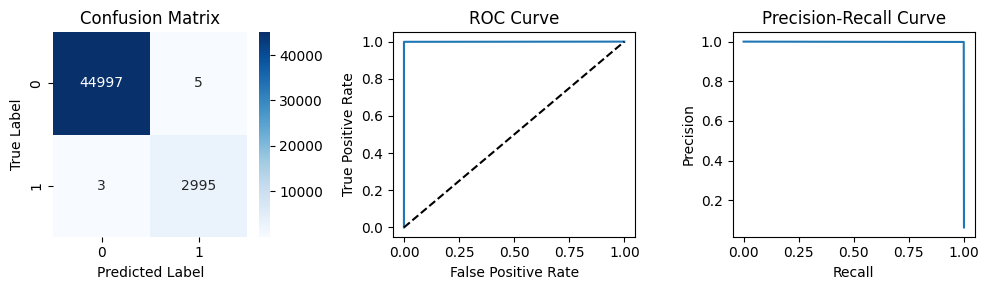

Decision Tree


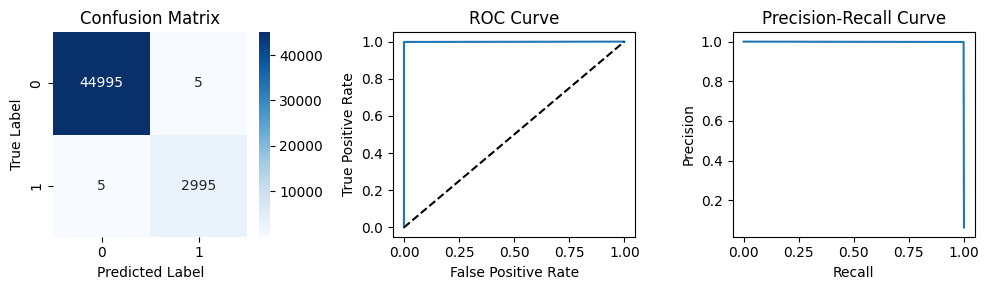

XGCLF


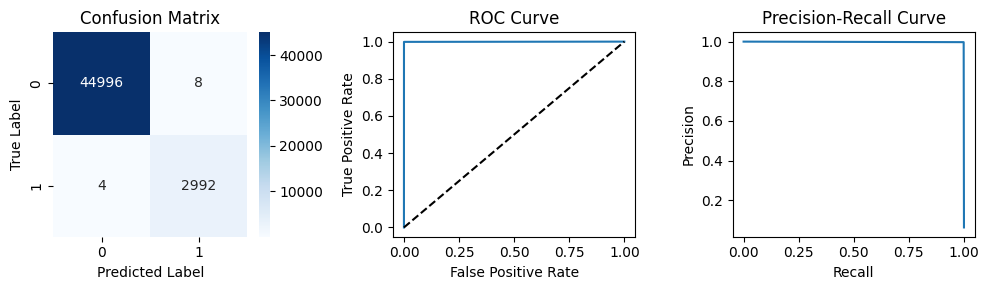

Adaboost


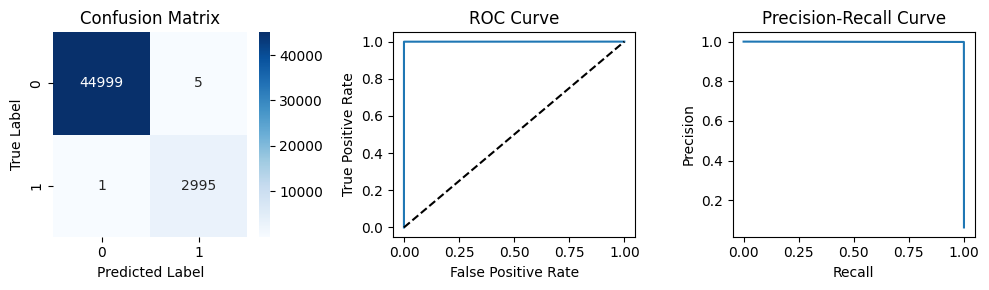

In [63]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, Y_train)

    X_train_prediction = model.predict(X_train)
    X_test_prediction = model.predict(X_test)

    # Create confusion matrix
    conf_matrix = confusion_matrix(X_test_prediction, Y_test)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds_roc = roc_curve(X_test_prediction, Y_test)
    roc_auc = auc(fpr, tpr)
    # Compute precision-recall pairs for different probability thresholds
    precision, recall, thresholds_pr = precision_recall_curve(X_test_prediction, Y_test)

    print(list(models.keys())[i])

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    #plt.legend()

    # Plot ROC curve
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #Receiver Operating Characteristic (ROC)
    plt.title('ROC Curve')
    #plt.legend()

    # Plot Precision-Recall curve
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()

Classification reports for each model

In [64]:
from tabulate import tabulate

In [65]:
clas_reps=[]
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, Y_train)

    X_train_prediction = model.predict(X_train)
    X_test_prediction = model.predict(X_test)

    clas_rep = classification_report(X_test_prediction, Y_test, target_names=['Class 0', 'Class 1'])
    #formated_clas_rep = clas_rep.replace('\n\n', '\n').replace('\n \n', '\n').replace('\n', '\n ')
    clas_reps.append({'Model': list(models.keys())[i],'Report':clas_rep})

#print(list(models.keys()))
#print('------------------------------------------------')
#print(clas_rep)
table = tabulate(clas_reps, headers='keys', tablefmt='heavy_grid')
print(table)


┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model               ┃ Report                                                ┃
┣━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃ Logistic Regression ┃ precision    recall  f1-score   support               ┃
┃                     ┃                                                       ┃
┃                     ┃      Class 0       0.95      0.94      0.95     45179 ┃
┃                     ┃      Class 1       0.16      0.17      0.17      2821 ┃
┃                     ┃                                                       ┃
┃                     ┃     accuracy                           0.90     48000 ┃
┃                     ┃    macro avg       0.55      0.56      0.56     48000 ┃
┃                     ┃ weighted avg       0.90      0.90      0.90     48000 ┃
┣━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃ Random Forest       ┃ precision    rec